# Sentiment Analysis on Movie Reviews

### Individual Task 2. Yana Herman. Multiclass classification

In [1]:
import os
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import nltk

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import unicodedata, re
import warnings

### 1. Preparation & Data analysis

In [2]:
train = pd.read_csv('train.tsv', '\t')
test = pd.read_csv('test.tsv', '\t')

- train.tsv contains the phrases and their associated sentiment labels. SentenceId helps to track which phrases belong to a single sentence.
- test.tsv contains just phrases. You must assign a sentiment label to each phrase.

In [3]:
#dataset shapes
print("Train :",train.shape)
print("Test:",test.shape)

Train : (156060, 4)
Test: (66292, 3)


#### Checking for NULL or NA

In [4]:
train.columns[train.isna().any()].tolist()

[]

In [5]:
test.columns[test.isna().any()].tolist()

[]

#### Sentiment labels

In [6]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


The sentiment labels are:

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

In [7]:
train['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [8]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


#### Number of phrases with sentiment labels

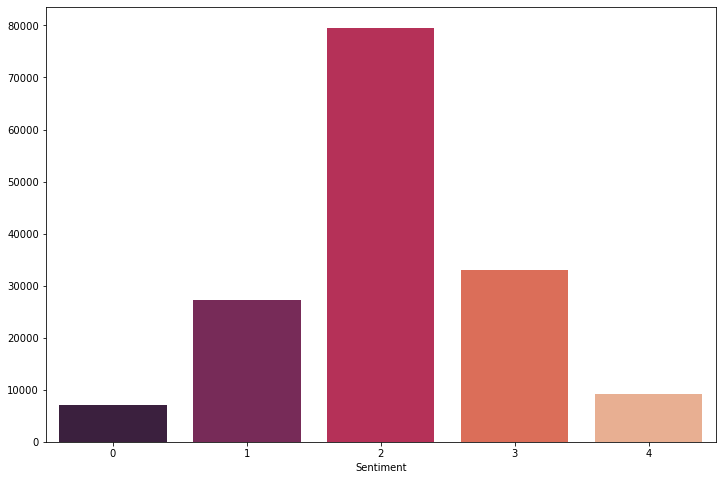

In [9]:
dist = train.groupby(["Sentiment"]).size()

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot( dist.keys(), dist.values, palette="rocket");

We will use words to create a feature matrix

In [10]:
words = train['Phrase'].apply(nltk.word_tokenize)

#### Data normalization

In [11]:
# For text cleaning

RE_NEXT_LINE = re.compile('\\n+', re.M)#RE_LINE_BREAK
RE_QUATATION = re.compile('^.*writes:$', re.M)
RE_QUATATION_MARKS = re.compile('(\W+|^)(\|>|>|\|)+', re.M)
STOP_WORDS = set(stopwords.words('english'))
STEMMER = PorterStemmer()
#The reason why we stem is to shorten the lookup, and normalize sentences.

TEXT_LENS = []

def _clean(docs):
    docs = map(rmQuatation, docs)
    docs = map(rmQuatationMarks, docs)
    docs = map(rmNumbers, docs)
    docs = map(rmNextLine, docs)
    docs = map(toLower, docs)
    docs = map(rmStopwords, docs)
    docs = map(rmTooShortOrLong, docs)
    docs = map(stemWords, docs)
    
    return list(docs)

def rmQuatation(doc):
    return RE_QUATATION.sub('', doc)

def rmQuatationMarks(doc):
    return RE_QUATATION_MARKS.sub(r'\1', doc)

def rmNextLine(doc):
    return RE_NEXT_LINE.sub(' ', doc).strip('\n\t ')

def rmNumbers(doc):
    return re.sub('[^a-zA-Z]', ' ', doc)

def toLower(doc):
    return doc.lower()

def rmStopwords(doc):
    doc = doc.split()
    doc = [w for w in doc if not w in STOP_WORDS]
    return ' '.join(doc)

def rmTooShortOrLong(doc):
    doc = doc.split()
    doc = [w for w in doc if len(w) >=3 and len(w) <= 15]
    return ' '.join(doc)

def stemWords(doc):
    doc = doc.split()
    doc = [STEMMER.stem(w) for w in doc]
    TEXT_LENS.append(len(doc))
    return ' '.join(doc)

In [12]:
df_train = pd.DataFrame.from_dict({
        'Phrase': _clean(train.Phrase),
        'Sentiment': train.Sentiment
    })
df_train

,Phrase,Sentiment
0,seri escapad demonstr adag good goos also good...,1
1,seri escapad demonstr adag good goos,2
2,seri,2
3,,2
4,seri,2
...,...,...
156055,hearst,2
156056,forc avuncular chortl,1
156057,avuncular chortl,3
156058,avuncular,2


In [13]:
df_test = pd.DataFrame.from_dict({
        'Phrase': _clean(test.Phrase)
    })
df_test

,Phrase
0,intermitt pleas mostli routin effort
1,intermitt pleas mostli routin effort
2,
3,intermitt pleas mostli routin effort
4,intermitt pleas mostli routin
...,...
66287,long wind predict scenario
66288,long wind predict scenario
66289,long wind
66290,long wind


#### Split train data into two subtraining sets

The training dataset doesn't have a column with labels (marks). So, let's split training set into train (train) and test(train_test) set.

In [14]:
train, train_test = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train.Sentiment)

In [15]:
train.shape

(124848, 2)

In [16]:
train_test

,Phrase,Sentiment
7963,passion somewhat flaw,2
5881,thoughtless,1
124471,move odd plot direct descend messag monger mor...,1
10624,one say bald year old actor play innoc boy car...,2
57016,simpl soapi,3
...,...,...
91083,mainli suspens excit,1
55121,total rehash,2
59330,enjoy hot chick,2
77841,indiffer,1


#### Setting labels

In [17]:
train.Sentiment.value_counts()

2    63665
3    26342
1    21818
4     7365
0     5658
Name: Sentiment, dtype: int64

In [18]:
train_test.Sentiment.value_counts()

2    15917
3     6585
1     5455
4     1841
0     1414
Name: Sentiment, dtype: int64

#### Text encoding

In [19]:
max(TEXT_LENS) #longest word

29

In [20]:
tfidf = TfidfVectorizer(max_features=max(TEXT_LENS)).fit(train.Phrase)

In [21]:
keys = sorted((key, token) for token, key in tfidf.vocabulary_.items())
keys[:10]

[(0, 'bad'),
 (1, 'charact'),
 (2, 'come'),
 (3, 'comedi'),
 (4, 'director'),
 (5, 'even'),
 (6, 'feel'),
 (7, 'film'),
 (8, 'funni'),
 (9, 'get')]

Using TfIdfVectorizer

Encoding according to the dictionary

In [22]:
X_train = tfidf.transform(train.Phrase).toarray()
print('X_train shape: %s' % (X_train.shape,))

X_train_test = tfidf.transform(train_test.Phrase).toarray()
print('X_train shape: %s' % (X_train_test.shape,))

X_test = tfidf.transform(test.Phrase).toarray()
print('X_test shape: %s' % (X_test.shape,))

X_train shape: (124848, 29)
X_train shape: (31212, 29)
X_test shape: (66292, 29)


#### Sentiment column

In [23]:
Y_train = train.Sentiment
print('Y_train shape: %s' % (Y_train.shape,))

Y_train_test = train_test.Sentiment
print('Y_train_test shape: %s' % (Y_train_test.shape,))

Y_train shape: (124848,)
Y_train_test shape: (31212,)


In [24]:
features = "Phrase"
transformer = Pipeline([("tfidf", TfidfVectorizer())])

In [25]:
preprocessor = ColumnTransformer(transformers=[('cat', transformer, features)])

## 2.Algorithm selection

### a.Custom Neural Network

In [26]:
Y_train_transf = OneHotEncoder().fit_transform(Y_train.values.reshape(-1, 1)).toarray()
print(Y_train)
print(Y_train_transf)
Y_train_transf.shape

35876     2
56148     3
125229    0
107990    4
24483     4
         ..
134537    3
21579     1
89654     2
49277     2
85772     2
Name: Sentiment, Length: 124848, dtype: int64
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


(124848, 5)

In [27]:
class NeuralNet:
    """
    
    NN for multi-class classification with mini-batch
    Attributes:
    ...
    """    
    def __init__(self, mbgd_size, neurons_in_layers, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.mbgd_size = mbgd_size
        self.neurons_in_layers = neurons_in_layers
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s
    
    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __softmax(self, Z):
        eZ = np.exp(Z - np.max(Z))
        return eZ / np.sum(eZ, axis=0, keepdims=True)

    def __initialize_parameters(self):
        neurons_in_layers = self.neurons_in_layers
        parameters = {}
        for i in range(1, len(neurons_in_layers)):
            parameters["W" + str(i)] = np.random.randn(neurons_in_layers[i], neurons_in_layers[i - 1]) * np.sqrt(1 / neurons_in_layers[i - 1])
            parameters["b" + str(i)] = np.zeros((neurons_in_layers[i], 1))
        self.parameters = parameters
       
    def __forward_propagation(self, X):
        parameters = self.parameters
        caches = []
        A = X
        L = len(parameters) // 2

        for i in range(1, L):
            prev_A = A
            W = parameters["W"+str(i)]
            b = parameters["b"+str(i)]
            
            Z = np.dot(W, prev_A) + b
            linear_cache = (prev_A, W, b)
            
            A = self.__softmax(Z)
            activation_cache = Z
            
            cache = (linear_cache, activation_cache)            
            caches.append(cache)   
            
        W = parameters["W"+str(L)]
        b = parameters["b"+str(L)]
        
        Z = np.dot(W, A) + b
        linear_cache = (A, W, b)
            
        AL = self.__softmax(Z)
        activation_cache = Z
            
        cache = (linear_cache, activation_cache)            
        caches.append(cache)  
        
        return AL, caches
    
    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T+ 1e-8))
        return J
        
    def __backward_propagation(self, X, Y, caches):
        grads = {}
        AL = X
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        
        linear_cache, activation_cache = caches[L-1]
        Z = activation_cache
        s = self.__softmax(Z)
        dZ = dAL * s * (1 - s)
        prev_A, W, b = linear_cache
        m = prev_A.shape[1]
        dW = 1 / m * np.dot(dZ, prev_A.T)
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prev_dA = np.dot(W.T, dZ)
        
        grads["dA" + str(L-1)] = prev_dA
        grads["dW" + str(L)] = dW
        grads["db" + str(L)] = db
        
        for i in reversed(range(L-1)):
            linear_cache, activation_cache = caches[i]
            Z = activation_cache
            s = self.__sigmoid(Z)
            dZ = prev_dA * s * (1 - s)
            prev_A, W, b = linear_cache
            m = prev_A.shape[1]
            dW = 1 / m * np.dot(dZ, prev_A.T)
            db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
            prev_dA = np.dot(W.T, dZ)
            
            grads["dA" + str(i)] = prev_dA
            grads["dW" + str(i + 1)] = dW
            grads["db" + str(i + 1)] = db
        return grads
   
    def __update_parameters(self, grads):
        parameters = self.parameters
        learning_rate = self.learning_rate

        for i in range(len(parameters) // 2):
            parameters["W" + str(i+1)] = parameters["W" + str(i+1)] - learning_rate * grads["dW" + str(i+1)]
            parameters["b" + str(i+1)] = parameters["b" + str(i+1)] - learning_rate * grads["db" + str(i+1)]
            
        self.parameters = parameters
        
    def __shuffle_and_separate(self, X, Y):            
        m = X.shape[1]
        SS_data = [] #for shuffled and separated data
        mbgd_size = self.mbgd_size
        
        perm = list(np.random.permutation(m))
        shuff_X = X[:, perm]        
        shuff_Y = Y[:, perm]

        for i in range(0, int(np.floor(m/mbgd_size))):
            batch_X = shuff_X[:, i*mbgd_size : (i + 1)*mbgd_size]
            batch_Y = shuff_Y[:, i*mbgd_size : (i + 1)*mbgd_size]
            
            batch = (batch_X, batch_Y)
            SS_data.append(batch)

        if m % mbgd_size != 0:
            batch_X = shuff_X[:, int(np.floor(m/mbgd_size))*mbgd_size:]
            batch_Y = shuff_Y[:, int(np.floor(m/mbgd_size))*mbgd_size:]
            
            batch = (batch_X, batch_Y)
            SS_data.append(batch)

        return SS_data
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        m = X.shape[1]
        costs = []
        
        self.__initialize_parameters()

        for i in range(0, self.num_iter):
            SS_data = self.__shuffle_and_separate(X, Y)
            
            for (batch_X, batch_Y) in SS_data:
                A, caches = self.__forward_propagation(batch_X)

                cost = self.compute_cost(A, batch_Y)

                grads = self.__backward_propagation(A, batch_Y, caches)

                self.__update_parameters(grads)
            
            costs.append(cost)

            if print_cost and i % 10 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 10 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        return np.argmax(positive_probs, axis = 1)

#### Hyperparameters

In [28]:
alpha = 0.01 #0.02
max_iters = 100 #150
minibatch_size = 4096 #5000
input_layer = X_train.shape[1]
output_layer = Y_train_transf.shape[1]

In [29]:
clf = NeuralNet(mbgd_size = minibatch_size, neurons_in_layers = [input_layer, 145, output_layer], normalize = True, learning_rate = alpha, num_iter = max_iters)

0-th iteration: 0.31389817737081044
10-th iteration: 0.27428528669699087
20-th iteration: 0.26127042375988163
30-th iteration: 0.2587900359084902
40-th iteration: 0.2547302343828388
50-th iteration: 0.2585893027694364
60-th iteration: 0.25422482577019434
70-th iteration: 0.254896298213612
80-th iteration: 0.26075954698715303
90-th iteration: 0.2531713214139004


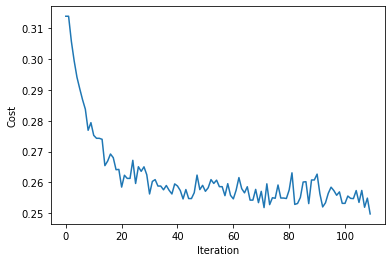

In [30]:
clf.fit(X_train, Y_train_transf)

In [31]:
#Train data prediction
Y_train_pred = clf.predict(X_train)
print(Y_train_pred)

[2 2 2 ... 2 2 2]


In [32]:
Y_train_test_pred = clf.predict(X_train_test)
print(Y_train_test_pred)

[2 2 2 ... 2 2 2]


In [33]:
#Test data prediction
Y_test_pred = clf.predict(X_test)
print(Y_test_pred)

[2 2 2 ... 2 2 2]


#### Train data results:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5658
           1       0.00      0.00      0.00     21818
           2       0.51      1.00      0.68     63665
           3       0.00      0.00      0.00     26342
           4       0.00      0.00      0.00      7365

    accuracy                           0.51    124848
   macro avg       0.10      0.20      0.14    124848
weighted avg       0.26      0.51      0.34    124848

Confusion matrix:
AxesSubplot(0.125,0.125;0.62x0.755)


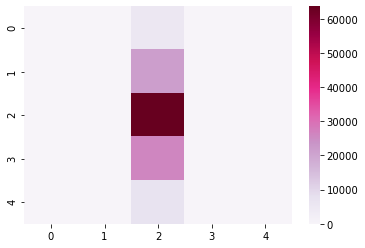

In [34]:
warnings.filterwarnings("ignore")
print(classification_report(Y_train, Y_train_pred))
print("Confusion matrix:")
print(sns.heatmap(confusion_matrix(Y_train, Y_train_pred), cmap="PuRd"))
warnings.filterwarnings("ignore")

#### Train_test data results:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1414
           1       0.00      0.00      0.00      5455
           2       0.51      1.00      0.68     15917
           3       0.00      0.00      0.00      6585
           4       0.00      0.00      0.00      1841

    accuracy                           0.51     31212
   macro avg       0.10      0.20      0.14     31212
weighted avg       0.26      0.51      0.34     31212

Confusion matrix:
AxesSubplot(0.125,0.125;0.62x0.755)


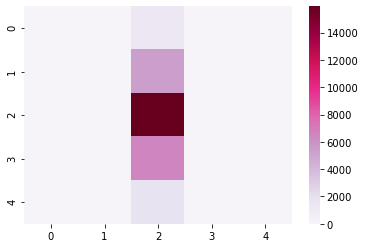

In [35]:
print(classification_report(Y_train_test, Y_train_test_pred))
print("Confusion matrix:")
print(sns.heatmap(confusion_matrix(Y_train_test, Y_train_test_pred), cmap="PuRd"))

### b. Sklearn classifier

In [36]:
svc = LinearSVC().fit(X_train, Y_train)

In [37]:
Y_train_pred = svc.predict(X_train)
Y_train_pred

array([2, 3, 2, ..., 2, 2, 2], dtype=int64)

In [38]:
Y_train_test_pred = svc.predict(X_train_test)
Y_train_test_pred

array([2, 2, 3, ..., 2, 2, 2], dtype=int64)

##### Train data results:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5658
           1       0.35      0.03      0.05     21818
           2       0.53      0.97      0.69     63665
           3       0.39      0.10      0.16     26342
           4       1.00      0.00      0.00      7365

    accuracy                           0.52    124848
   macro avg       0.46      0.22      0.18    124848
weighted avg       0.47      0.52      0.39    124848

Confusion matrix:
AxesSubplot(0.125,0.125;0.62x0.755)


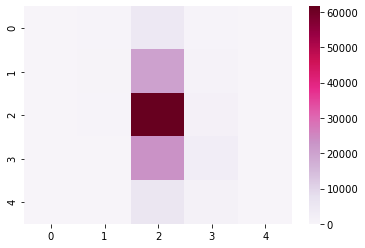

In [39]:
print(classification_report(Y_train, Y_train_pred))
print("Confusion matrix:")
print(sns.heatmap(confusion_matrix(Y_train, Y_train_pred), cmap="PuRd"))

#### Train_test data results:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1414
           1       0.38      0.03      0.05      5455
           2       0.53      0.97      0.68     15917
           3       0.38      0.10      0.16      6585
           4       1.00      0.00      0.00      1841

    accuracy                           0.52     31212
   macro avg       0.46      0.22      0.18     31212
weighted avg       0.47      0.52      0.39     31212

Confusion matrix:
AxesSubplot(0.125,0.125;0.62x0.755)


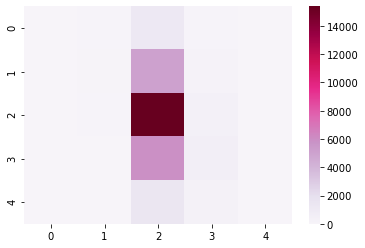

In [40]:
print(classification_report(Y_train_test, Y_train_test_pred))
print("Confusion matrix:")
print(sns.heatmap(confusion_matrix(Y_train_test, Y_train_test_pred), cmap="PuRd"))

### c. Hyperparameter selection

In [41]:
X_train3 = df_train.drop(columns = ['Sentiment'])
Y_train3 = df_train.drop(columns = ['Phrase'])

In [42]:
#new pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ('classifier', LinearSVC())])

In [43]:
pipeline.fit(X_train3, Y_train3)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('tfidf',
                                                                   TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                                                   decode_error='strict',
                                                                                   dtype=<class 'numpy.float64'>,
                                                                                   encoding='utf-8',
                                      

In [44]:
Y_train_pred = pipeline.predict(X_train3)

              precision    recall  f1-score   support

           0       0.65      0.35      0.45      7072
           1       0.61      0.49      0.54     27273
           2       0.72      0.88      0.79     79582
           3       0.61      0.53      0.57     32927
           4       0.67      0.36      0.47      9206

    accuracy                           0.68    156060
   macro avg       0.65      0.52      0.57    156060
weighted avg       0.67      0.68      0.67    156060

Confusion matrix:
AxesSubplot(0.125,0.125;0.62x0.755)


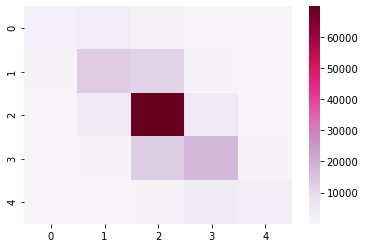

In [45]:
print(classification_report(Y_train3, Y_train_pred))
print("Confusion matrix:")
print(sns.heatmap(confusion_matrix(Y_train3, Y_train_pred), cmap="PuRd"))

In [46]:
#Serch Grid for Best Parameters
# Possible parameters:
param_grid = {
    'solver': ['adam'],
    'max_iter': [100, 50],
    'learning_rate_init': [0.1, 0.01],
    'hidden_layer_sizes': [(100,), (50,)],
    'random_state': [42]
}

search = GridSearchCV(MLPClassifier(), param_grid, n_jobs=-1)

search.fit(X_train, Y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
warnings.filterwarnings("ignore")

Best parameter (CV score=0.523):
{'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 100, 'random_state': 42, 'solver': 'adam'}


In [48]:
accuracy_score(Y_train_test, search.predict(X_train_test))

0.5208253235934897